In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈

# GPU 선택 -> '1': 두 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    '가렵다',
    '기절',
    '부러지다',
    '어제',
    '어지러움',
    '열나다',
    '오늘',
    '진통제',
    '창백하다',
    '토하다'
]

data = np.concatenate([
    np.load('C:/Users/mshof/Desktop/seq_data/seq_pad_1715052175.npy'),
    np.load('C:/Users/mshof/Desktop/seq_data/seq_flip_pad_1715074873.npy')
], axis=0)

data.shape
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(41706, 30, 253)

In [3]:
# 시퀀스의 마지막 열 제외한 모든 열 가져와 할당
# 첫 번째 행의 마지막 열은 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
print(labels.shape)
print(np.unique(labels))    # 레이블 값 출력

(41706, 30, 253)
(41706,)
[0. 1. 2. 3. 4. 5. 7. 8. 9.]


In [4]:
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(41706, 10)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

# train data : validation data : test data = 6 : 2 : 2
x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(25023, 30, 252) (25023, 10)
(8341, 30, 252) (8341, 10)
(8342, 30, 252) (8342, 10)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128,  activation='relu', input_shape=x_train.shape[1:3]),   # input -> (None, 30, 252)
    Dense(64, activation='relu'),
    Dense(len(actions), activation='softmax'),
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               195072    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 203978 (796.79 KB)
Trainable params: 203978 (796.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, verbose=1, mode='auto')
    ]
)

Epoch 1/50


780/782 [============================>.] - ETA: 0s - loss: 1.3494 - acc: 0.4674
Epoch 1: val_acc improved from -inf to 0.59681, saving model to models\model.h5
782/782 [==============================] - 25s 27ms/step - loss: 1.3485 - acc: 0.4677 - val_loss: 1.0197 - val_acc: 0.5968 - lr: 0.0010
Epoch 2/50
  4/782 [..............................] - ETA: 15s - loss: 1.1237 - acc: 0.5391

c:\Users\mshof\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - ETA: 0s - loss: 0.9282 - acc: 0.6402
Epoch 2: val_acc improved from 0.59681 to 0.65724, saving model to models\model.h5
782/782 [==============================] - 18s 24ms/step - loss: 0.9282 - acc: 0.6402 - val_loss: 0.8869 - val_acc: 0.6572 - lr: 0.0010
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 0.7643 - acc: 0.7077
Epoch 3: val_acc improved from 0.65724 to 0.73756, saving model to models\model.h5
782/782 [==============================] - 17s 22ms/step - loss: 0.7643 - acc: 0.7077 - val_loss: 0.6785 - val_acc: 0.7376 - lr: 0.0010
Epoch 4/50
781/782 [============================>.] - ETA: 0s - loss: 0.6454 - acc: 0.7534
Epoch 4: val_acc improved from 0.73756 to 0.74931, saving model to models\model.h5
782/782 [==============================] - 17s 22ms/step - loss: 0.6455 - acc: 0.7533 - val_loss: 0.6355 - val_acc: 0.7493 - lr: 0.0010
Epoch 5/50
782/782 [==============================] - ETA: 0s - loss: 0.5688 - ac

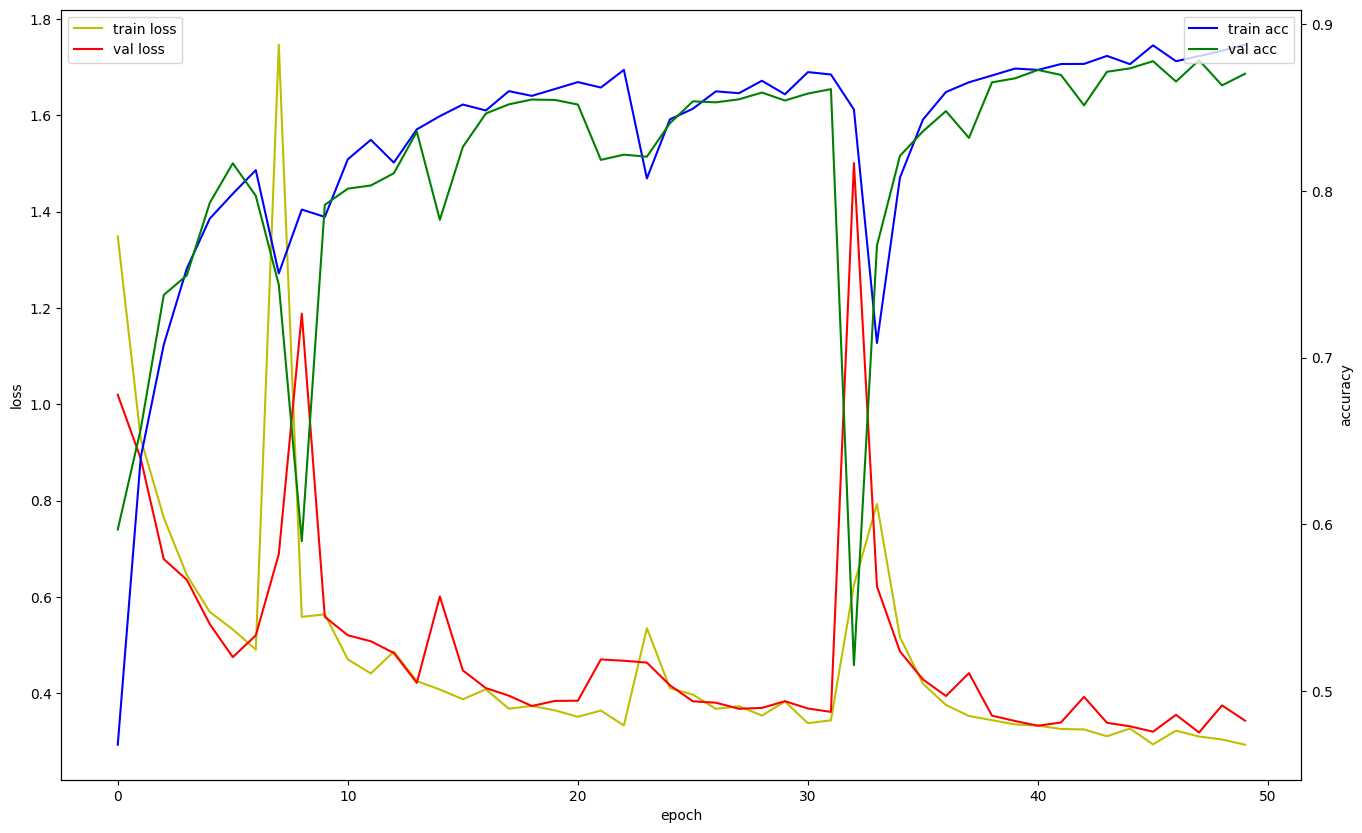

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 손실: {test_loss:.3f}")
print(f"테스트 정확도: {test_acc:.3f}")

y_pred = model.predict(x_val)

# 다중 레이블 혼동 행렬로 모델 평가
# [[True Negative, False Positive],
# [False Negative, True Positive]]
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

261/261 [==============================] - 2s 7ms/step - loss: 0.3087 - acc: 0.8822
테스트 손실: 0.309
테스트 정확도: 0.882
261/261 [==============================] - 2s 8ms/step


array([[[7423,    6],
        [ 130,  782]],

       [[7413,    2],
        [ 126,  800]],

       [[7398,   12],
        [ 190,  741]],

       [[7384,   22],
        [ 194,  741]],

       [[7351,   17],
        [ 171,  802]],

       [[6543,  881],
        [  11,  906]],

       [[7418,    9],
        [  23,  891]],

       [[7378,   27],
        [  30,  906]],

       [[7406,   38],
        [ 139,  758]]], dtype=int64)